In [37]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [2]:
import sys
print(sys.version)


3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]


# Chuẩn bị dữ liệu

In [42]:
# Tải dữ liệu cổ phiếu của Google từ Yahoo Finance
data = yf.download('GOOGL', start='2008-01-01', end='2024-01-01')
data.head(10)


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2008-01-02 00:00:00+00:00,17.104544,17.146896,17.451702,16.960211,17.339088,172103724
2008-01-03 00:00:00+00:00,17.108038,17.150400,17.188438,16.929930,17.148649,129969900
2008-01-04 00:00:00+00:00,16.400829,16.441441,17.041040,16.391392,17.009258,214177608
2008-01-07 00:00:00+00:00,16.207367,16.247498,16.573574,15.949700,16.364864,255879864
2008-01-08 00:00:00+00:00,15.768762,15.807808,16.515516,15.790791,16.341341,213350436
2008-01-09 00:00:00+00:00,16.305969,16.346346,16.349850,15.578328,15.766767,269318412
2008-01-10 00:00:00+00:00,16.144459,16.184435,16.446445,16.018768,16.141392,253114632
2008-01-11 00:00:00+00:00,15.932771,15.972222,16.253002,15.768519,16.083584,198880920


In [29]:
# Chọn giá đóng cửa để dự đoán
close_prices = data['Close'].values
close_prices = close_prices.reshape(-1, 1) 
close_prices


array([[ 17.14689636],
       [ 17.15040016],
       [ 16.44144058],
       ...,
       [140.36999512],
       [140.22999573],
       [139.69000244]])

In [43]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)
scaled_data

array([[0.07464957],
       [0.07467401],
       [0.06972994],
       ...,
       [0.93396955],
       [0.93299324],
       [0.92922749]])

In [31]:
train_data = scaled_data[:int(len(scaled_data) * 0.8)]  # 80% dữ liệu cho huấn luyện
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


# Xây dựng mô hình

In [44]:
# Định nghĩa Learning Rate
learning_rate = 0.0001

# Tạo mô hình LSTM
model = Sequential()

# Lớp LSTM đầu tiên với Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Thêm lớp Dropout, tỷ lệ 20%

# Lớp LSTM thứ hai với Dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))  # Thêm lớp Dropout, tỷ lệ 20%

# Lớp đầu ra
model.add(Dense(1))

# Tạo optimizer với Learning Rate
optimizer = Adam(learning_rate=learning_rate)

# Biên dịch mô hình với optimizer đã định nghĩa
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Xem tóm tắt mô hình
model.summary()


c:\Users\HoaAn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=2200, batch_size=32)


Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0175
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0011
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 6.6472e-04
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 7.3716e-04
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.8841e-04
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.4973e-04
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 5.6697e-04
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 5.1572e-04
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 5.1499e-04
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 4.9959e-04
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 4.8445e-04
Epoch 12/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 4.7376e-04
Epoch 13/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 5.1416e-04
Epoch 14/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 5.1594e-04
Epoch 15/

# Kiểm tra mô hình

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


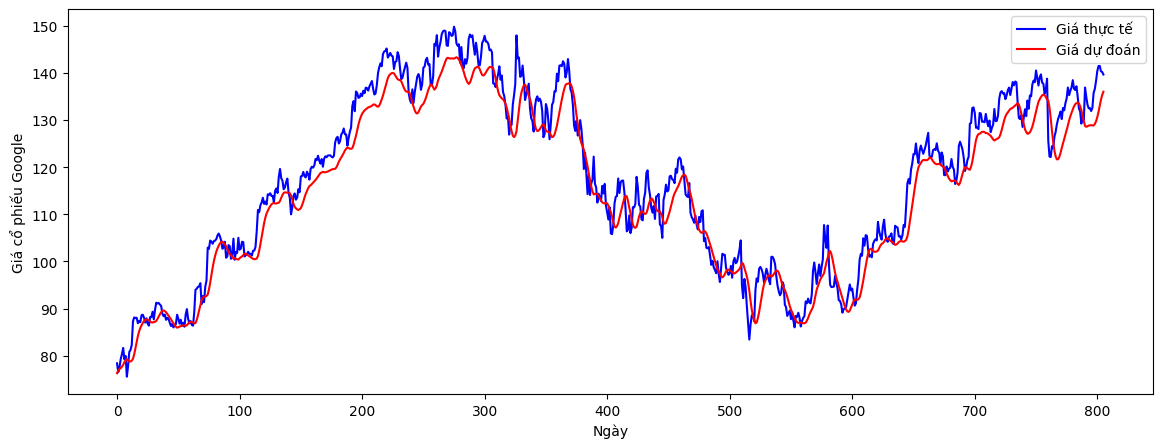

In [46]:
# Chuẩn bị tập kiểm thử
test_data = scaled_data[int(len(scaled_data) * 0.8) - 60:]
X_test, y_test = [], close_prices[int(len(scaled_data) * 0.8):]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Dự đoán giá trị
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Chuyển lại về thang đo ban đầu

# Vẽ biểu đồ kết quả
plt.figure(figsize=(14,5))
plt.plot(y_test, color='blue', label='Giá thực tế')
plt.plot(predictions, color='red', label='Giá dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu Google')
plt.legend()
plt.show()


# Dự đoán giá trị trong tương lai

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

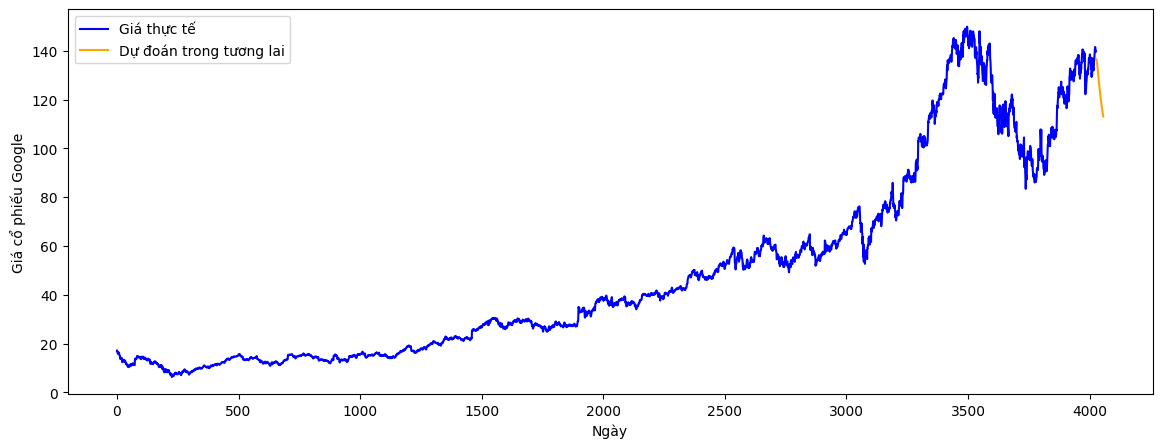

In [47]:
# Số ngày muốn dự đoán trong tương lai
future_days = 30

# Lấy dữ liệu 60 ngày cuối cùng từ tập dữ liệu huấn luyện để làm đầu vào cho dự đoán tương lai
input_data = scaled_data[-60:]
input_data = input_data.reshape(1, 60, 1)

# Dự đoán trong tương lai
future_predictions = []
for _ in range(future_days):
    # Dự đoán ngày tiếp theo
    predicted_price = model.predict(input_data)
    future_predictions.append(predicted_price[0, 0])
    
    # Cập nhật dữ liệu đầu vào bằng cách bỏ ngày đầu và thêm dự đoán mới nhất
    input_data = np.append(input_data[0, 1:], predicted_price[0, 0])
    input_data = input_data.reshape(1, 60, 1)

# Chuyển lại về giá trị gốc cho các dự đoán
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Vẽ biểu đồ các dự đoán tương lai
plt.figure(figsize=(14,5))
plt.plot(np.arange(len(close_prices)), close_prices, color='blue', label='Giá thực tế')
plt.plot(np.arange(len(close_prices), len(close_prices) + future_days), future_predictions, color='orange', label='Dự đoán trong tương lai')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu Google')
plt.legend()
plt.show()
